# 0. Load Data

In [1]:
import math 
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Isolation Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# VAE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics

In [2]:
cell_ids = pd.read_csv("data/cells_reduced/cell_ids.csv",header=None)
cell_ids = [x for lst in cell_ids.values.tolist() for x in lst]
cell_ids

[2.2265366483183206e+17,
 7.315874467898523e+16,
 9.10621795573706e+16,
 3.8447326973958944e+17,
 4.262775046883192e+17]

In [3]:
cells = []
for cell_id in cell_ids:
    file_name = "cell_"+str(cell_id)+'.csv'
    cells.append(pd.read_csv(f"data/cells_reduced/{file_name}"))

In [5]:
cells[0].shape

(1655, 16)

In [6]:
df_cell = cells[0].drop(['cell_id','index'],axis=1)

# 1. Isolation Forest

In [7]:
IF=IsolationForest(n_estimators=150, 
                      max_samples ='auto', 
                      max_features=1)

In [8]:
IF.fit(df_cell)
# score_samples = - score  
IF_score = -1 * IF.score_samples(df_cell)
IF_score[:20]

array([0.48175558, 0.47446694, 0.506927  , 0.48394299, 0.46416705,
       0.49108916, 0.48599093, 0.4350224 , 0.43560128, 0.45326339,
       0.4548446 , 0.46787218, 0.45467894, 0.47472275, 0.47315099,
       0.46628523, 0.44992219, 0.44597116, 0.44544939, 0.45241848])

# 2. VAE

[keras - Variational AutoEncoder 官方代码范例(复杂)](https://keras.io/examples/generative/vae/)

[keras - AE/VAE 相对简单的代码构建](https://blog.keras.io/building-autoencoders-in-keras.html)

[keras - 中等程度AVE 但是有点乱](https://github.com/keras-team/keras/blob/2c8d1d03599cc03243bce8f07ed9c4a3d5f384f9/examples/variational_autoencoder.py)







[中文VAE理论+代码](https://blog.csdn.net/weixin_37737254/article/details/102920263)

[keras - 函数式API](https://keras.io/guides/functional_api/)

[keras - Conv1D](https://keras-zh.readthedocs.io/layers/convolutional/)


## 2.1 Build model

In [10]:
################  Standarlize   #################
df_cell = cells[0].drop(['cell_id','index'],axis=1)

df_cell_1 = StandardScaler().fit_transform(df_cell)
df_cell_1 = np.expand_dims(df_cell_1,axis=1)

In [11]:
################ Define sampling function #################
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [12]:
################ Build Encoder #################
original_dim = df_cell.shape[1]
intermediate_dim = 32
latent_dim = 2

# encoder input
inputs = keras.Input(shape=(1,original_dim))
x = layers.Conv1D(filters=intermediate_dim, kernel_size=3, padding="same", activation="relu")(inputs)
x = layers.Dropout(rate=0.2)(x)
x = layers.Flatten()(x)

# the output of encoder
z_mean      = layers.Dense(latent_dim, name="z_mean")(x)
z_log_sigma = layers.Dense(latent_dim, name="z_log_var")(x)
z           = layers.Lambda(sampling)([z_mean, z_log_sigma])

# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 14)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1, 32)        1376        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1, 32)        0           ['conv1d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 32)           0           ['dropout[0][0]']                
                                                                                            

In [13]:
################ Build Decoder #################

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(1*intermediate_dim, activation='relu')(latent_inputs)
x = layers.Reshape((1,intermediate_dim))(x)
x = layers.Conv1DTranspose(filters=intermediate_dim, kernel_size=3, padding="same", activation="relu")(x)
x = layers.Dropout(rate=0.2)(x)
outputs = layers.Conv1DTranspose(filters=original_dim, kernel_size=3, padding="same", activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 32)                96        
                                                                 
 reshape (Reshape)           (None, 1, 32)             0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 1, 32)            3104      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 1, 32)             0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 1, 14)            1358      
 ranspose)                                                 

In [14]:
################ Instantiate VAE model ################# 
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

################     Loss Function      ################# 
reconstruction_loss = keras.losses.mean_squared_error(inputs, outputs)
# reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + 0.0001*kl_loss) #调整比例？？
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')


ps: weight of kl_loss?    

ref1.[theoretical insight](https://stats.stackexchange.com/questions/332179/how-to-weight-kld-loss-vs-reconstruction-loss-in-variational-auto-encoder)

ref2.[a more specific example](https://stats.stackexchange.com/questions/341954/balancing-reconstruction-vs-kl-loss-variational-autoencoder)

In [16]:
# Train model
vae.fit(df_cell_1, df_cell_1,
        epochs=100,
        batch_size=256)

Epoch 1/100
7/7 [==============================] - 0s 3ms/step - loss: 0.8439
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 0.8372
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 0.8319
Epoch 4/100
7/7 [==============================] - 0s 4ms/step - loss: 0.8254
Epoch 5/100
7/7 [==============================] - 0s 4ms/step - loss: 0.8241
Epoch 6/100
7/7 [==============================] - 0s 4ms/step - loss: 0.9127
Epoch 7/100
7/7 [==============================] - 0s 4ms/step - loss: 0.8353
Epoch 8/100
7/7 [==============================] - 0s 4ms/step - loss: 0.8314
Epoch 9/100
7/7 [==============================] - 0s 4ms/step - loss: 0.8228
Epoch 10/100
7/7 [==============================] - 0s 4ms/step - loss: 0.8266
Epoch 11/100
7/7 [==============================] - 0s 3ms/step - loss: 0.8336
Epoch 12/100
7/7 [==============================] - 0s 4ms/step - loss: 0.8365
Epoch 13/100
7/7 [==============================] - 0s 4ms/st

In [11]:
vae.save("model/2_VAE/cell0/")

INFO:tensorflow:Assets written to: model/2_VAE/cell0\assets


## 2.2 [Detect Anomaly](https://towardsdatascience.com/hands-on-anomaly-detection-with-variational-autoencoders-d4044672acd5)
Detect anomaly by finding those who have a high reconstruction loss.


Steps:
1. Measure error between the original train (clean/normal) set and the output of the model, and generate an error vector representing the error term of each sample.

2. Find a relatively extreme value on that vector to use as your error threshold.

3. Run the model over the test or real data, in which anomalies are probably mixed with normal data.

4. Measure the reconstruction error and mark samples that exhibit an error term higher than the error threshold as anomalies.

In [17]:
def mse(original,reconstructed):
    return np.mean(np.sum((original-reconstructed)**2,axis=1),axis=1)

In [18]:
from sklearn.preprocessing import MinMaxScaler
df_cell_1_pred = vae.predict(df_cell_1)
df_cell_1_loss = mse(df_cell_1,df_cell_1_pred)
df_cell_1_loss[:20]

array([0.55392504, 0.6009765 , 0.86313724, 0.67948444, 0.55947028,
       0.4986129 , 1.25471552, 0.22403687, 0.26962849, 0.38270922,
       0.46923114, 0.4450706 , 0.3828676 , 0.83589445, 0.51378467,
       0.50822273, 0.30963367, 0.21867796, 0.18622372, 0.23598063])

# 3. VAE + IF

In [20]:
encoder_output = encoder.predict(df_cell_1)
encoder_output

[array([[-0.8999783 , -0.77241725],
        [-1.1815928 , -1.0034804 ],
        [-2.3808825 , -1.9854629 ],
        ...,
        [-1.9450938 ,  7.3654284 ],
        [-3.3809748 ,  8.914486  ],
        [-3.4060364 ,  8.535825  ]], dtype=float32),
 array([[-0.4765499 , -1.1700668 ],
        [-0.5346675 , -1.351898  ],
        [-0.67202735, -2.2538095 ],
        ...,
        [-2.406165  , -1.6943064 ],
        [-2.7794204 , -1.7402632 ],
        [-2.915082  , -1.7701969 ]], dtype=float32),
 array([[-0.885783 , -0.8322596],
        [-1.1128069, -0.9885305],
        [-2.4322908, -1.9801416],
        ...,
        [-1.947157 ,  7.36673  ],
        [-3.3806365,  8.919479 ],
        [-3.403241 ,  8.535118 ]], dtype=float32)]

In [21]:
def feature_from_encoder(encoder_output):
    # take mean and log_var as features
    df_encoded_mean   = pd.DataFrame(encoder_output[0],columns=["mean1","mean2"])
    df_encoded_logvar = pd.DataFrame(encoder_output[1],columns=["log_var1","log_var2"])
    df_encoded        = df_encoded_mean.join(df_encoded_logvar)
    return df_encoded

df_encoded = feature_from_encoder(encoder_output)
df_encoded

,mean1,mean2,log_var1,log_var2
0,-0.899978,-0.772417,-0.476550,-1.170067
1,-1.181593,-1.003480,-0.534667,-1.351898
2,-2.380883,-1.985463,-0.672027,-2.253809
3,-2.108607,-1.730262,-0.664575,-2.096219
4,-0.944334,-0.828397,-0.612430,-1.431621
...,...,...,...,...
1650,-1.654880,8.540416,-2.508860,-1.829970
1651,-2.199219,8.129313,-2.530215,-1.762223
1652,-1.945094,7.365428,-2.406165,-1.694306
1653,-3.380975,8.914486,-2.779420,-1.740263


In [22]:
VAE_IF=IsolationForest(n_estimators=150, 
                      max_samples ='auto', 
                      max_features=1)
VAE_IF.fit(df_encoded)

In [23]:
VAE_IF_score = -1 * VAE_IF.score_samples(df_encoded)
VAE_IF_score[:20]

array([0.48681341, 0.47084319, 0.5086729 , 0.49836519, 0.45914374,
       0.50118792, 0.55347293, 0.42565384, 0.43608581, 0.45923312,
       0.49876159, 0.47042986, 0.47521283, 0.43730392, 0.49579145,
       0.43530352, 0.4472817 , 0.44184955, 0.47709959, 0.44103984])

# 4. Add prediction as columns

In [24]:
df_cell['IF_score'] = IF_score
df_cell['IF_score'].describe()

count    1655.000000
mean        0.464604
std         0.020510
min         0.428938
25%         0.449333
50%         0.460851
75%         0.476361
max         0.566209
Name: IF_score, dtype: float64

In [25]:
df_cell['VAE_loss'] = df_cell_1_loss
df_cell['VAE_loss'].describe()

count    1655.000000
mean        0.812863
std         3.201124
min         0.050011
25%         0.319973
50%         0.498830
75%         0.755240
max       118.378702
Name: VAE_loss, dtype: float64

In [26]:
df_cell['VAE_IF_score'] = VAE_IF_score
df_cell['VAE_IF_score'].describe()

count    1655.000000
mean        0.468952
std         0.043137
min         0.420409
25%         0.443435
50%         0.454670
75%         0.478274
max         0.800672
Name: VAE_IF_score, dtype: float64

# 5.Visualization

## 5.1 Visualize with features chosen manually

In [27]:
df_cell.head()

,DL_TRAFFIC_VOLUME,UL_TRAFFIC_VOLUME,Inter_X2_based_HO_prep,VoLTE_total_traffic,INTRA_FREQ_HO_SR_RATIO,RRC_SR_RATIO,CELL_AVAILABILITY_RATIO,RACH_Stp_Completion_SR_RATIO,E_RAB_QCI1_DR_RATIO,DCR_LTE_RATIO,CSSR_LTE_RATIO,LTE_INTER_ENODEB_HOSR_RATIO,Inter_RAT_HO_SR_GERAN_SRVCC_RATIO,HOUR,IF_score,VAE_loss,VAE_IF_score
0,3.779737e+10,3.947172e+09,15.0,4727.0,0.809859,0.992427,1.0,0.962688,0.000000,0.001761,0.996041,0.400000,0.963636,0,0.481756,0.553925,0.486813
1,3.684898e+10,4.088752e+09,6.0,3076.0,0.886792,0.993288,1.0,0.973207,0.000000,0.002468,0.995465,0.500000,1.000000,1,0.474467,0.600976,0.470843
2,3.292677e+10,5.016897e+09,8.0,3501.0,0.938356,0.994664,1.0,0.966330,0.013889,0.003077,0.996044,0.375000,1.000000,2,0.506927,0.863137,0.508673
3,3.021547e+10,5.139107e+09,9.0,2275.0,0.860215,0.994819,1.0,0.943216,0.000000,0.001721,0.995920,0.777778,0.947368,3,0.483943,0.679484,0.498365
4,3.082176e+10,4.250716e+09,17.0,2178.0,0.840426,0.995952,1.0,0.936256,0.000000,0.002213,0.995628,0.764706,1.000000,4,0.464167,0.559470,0.459144


In [29]:
# choose some most irrelated features to plot 
import seaborn as sns

df_features = df_cell.drop(['IF_score','VAE_loss','VAE_IF_score'],axis=1)
df_indices  = df_cell[['IF_score','VAE_loss','VAE_IF_score']]

<AxesSubplot:>

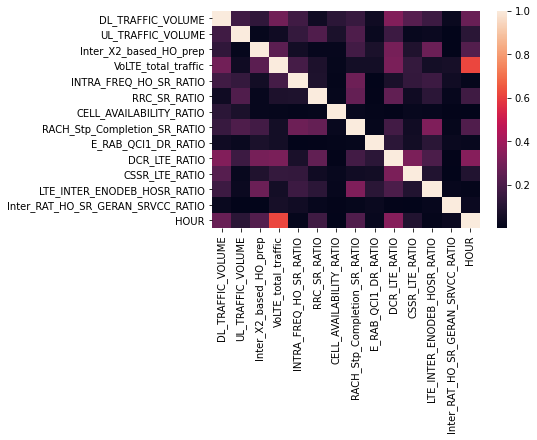

In [34]:
sns.heatmap(abs(df_features.corr()))

In [45]:
def anomaly_visualization(df,feature_list:list,indice:str):
    """
    Visualize anomalies in 2D/3D scatter plot by using 
    
    INPUT
    @feature_list: a list of feature names, it's length should be 2 or 3
    @indice : str, the name of indice column
    
    """
    dimention   = len(feature_list)
    df_features = df[feature_list]
    indice      = df[indice]
  
    fig = plt.figure(figsize=(8,8))
    if dimention == 3:
        ax1 = fig.add_subplot(111,  projection='3d')
        ax1.scatter(df_features[feature_list[0]],df_features[feature_list[1]],df_features[feature_list[2]],
                    s=4,lw=1,c=indice*10,alpha=0.5)
        
    elif dimention == 2:
        ax2 = fig.gca()
        ax2.scatter(df_features[feature_list[0]],df_features[feature_list[1]],
                    c=indice*10,
                    s=5,alpha=0.8)
    
    plt.show()
    

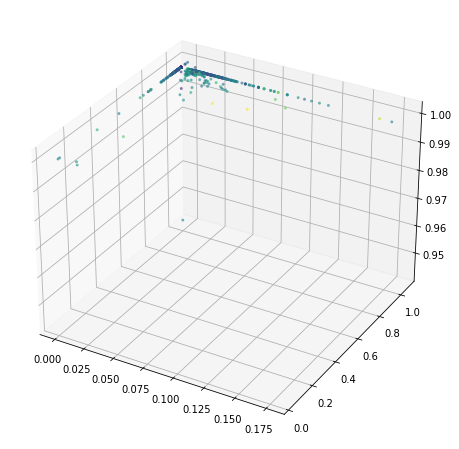

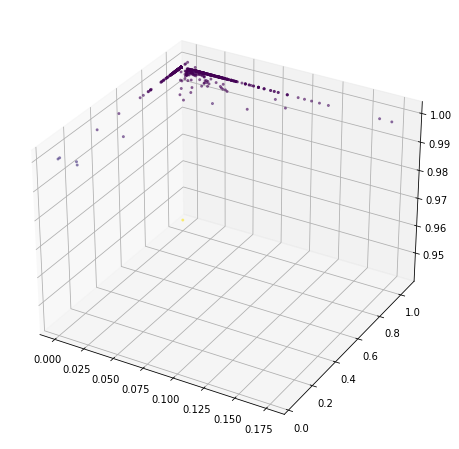

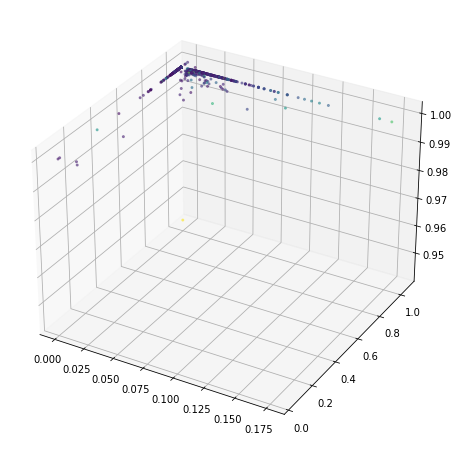

In [46]:
some_features = ['E_RAB_QCI1_DR_RATIO','Inter_RAT_HO_SR_GERAN_SRVCC_RATIO','CELL_AVAILABILITY_RATIO']
indices = ['IF_score','VAE_loss','VAE_IF_score']
for indice in indices:
    anomaly_visualization(df_cell,some_features,indice)

Clearly, with the 3 features selected, it doesn't seem to be able to illustrate our metrics very well.. We'll try to use PCA to seem if it will be better

## 5.2 Visualize with PCA
Use PCA to reduce dimension to 2/3 in order to plot. The color of scatter points indicates the value of indicator(the lighter the color is, the higher the value is)

In [58]:
def anomaly_visualization(df_features,df_metrics,title_name):
    """
    Visualize anomalies in 2D/3D scatter plot  
    
    INPUT
    @df : a dataframe where the prediction result is in the 'anomaly' column
    
    """
    index = df_features.index
    
    # recude the dimension for visualization
    X_3d = pd.DataFrame(PCA(3).fit_transform(df_features),index=index)
    X_2d = pd.DataFrame(PCA(2).fit_transform(df_features),index=index)
    
    # plot
    fig = plt.figure(figsize=(10,5))
    # 3D
    ax1 = fig.add_subplot(121,  projection='3d')
    ax1.scatter(X_3d.loc[:,0],X_3d.loc[:,1],X_3d.loc[:,2],
                s=4,lw=1,c=df_metrics*10,alpha=0.5)
    ax1.set_title(title_name + "(3D)")
    # 2D
    ax2 = fig.add_subplot(133)
    ax2.scatter(X_2d.loc[:,0],X_2d.loc[:,1],
                c=df_metrics*10,
                s=5,alpha=0.8)
    ax2.set_title(title_name+"(2D)")
    plt.show()
    

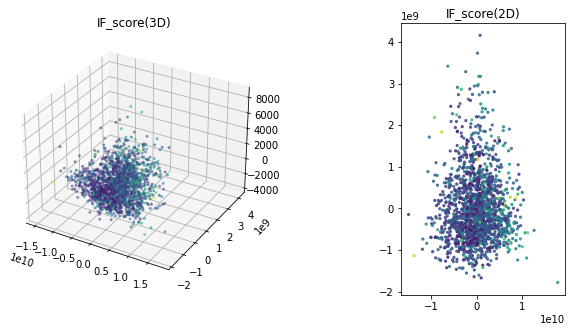

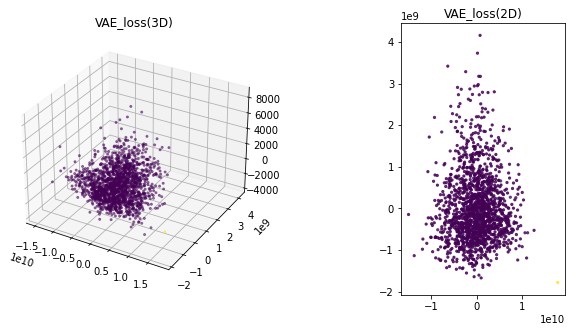

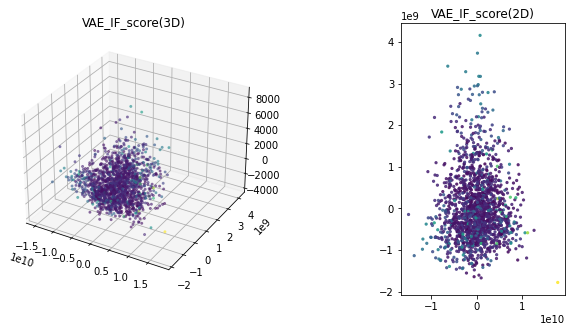

In [59]:
indices = ['IF_score','VAE_loss','VAE_IF_score']
for indice in indices:
    anomaly_visualization(df_features,df_cell[indice],indice)

It seems that the third indicator(VAE+IF) seems to work well (the points in the periphery are usually lighter in color, which means they score higher as anomalies), although it clearly needs further improvement

# Codes alternatifs
Below are the code might be useful for visualization (have nothing to do with modeling, you can skip them :) 

In [ ]:
def anomalyPercent(model, df_test):
    """
    Calculate the percentage of anomalies in the testset
    
    """
    df_pred = df_test.copy()
    df_pred['anomaly'] = model.predict(df_test)
    pct  = (df_pred['anomaly']==-1).sum()/len(df_test)
    
#     # map 1 -> 0, -1 -> 1
#     reset_value = lambda x: 1 if x==-1 else 0
#     df_test['anomaly'] = df_test['anomaly'].map(reset_value)
    
    return pct, df_pred

In [ ]:
def anomaly_visualization(df):
    """
    Visualize anomalies in 2D/3D scatter plot  
    
    INPUT
    @df : a dataframe where the prediction result is in the 'anomaly' column
    
    """
    index = df.index
    outlier_index = list(df[df['anomaly']==-1].index)
    
    # nomalize the metrics
    X = StandardScaler().fit_transform(df.drop('anomaly',axis=1))
    
    # recude the dimension for visualization
    X_3d = pd.DataFrame(PCA(3).fit_transform(X),index=index)
    X_3d_outliers = X_3d.reindex(outlier_index)
    X_2d = pd.DataFrame(PCA(2).fit_transform(X),index=index)
    X_2d_outliers = X_2d.reindex(outlier_index)
    
    # plot
    fig = plt.figure(figsize=(10,5))
    # 3D
    ax1 = fig.add_subplot(121,  projection='3d')
    ax1.scatter(X_3d.loc[:,0],X_3d.loc[:,1],X_3d.loc[:,2],
                s=4,lw=1,label="inliers",c="green",alpha=0.5)
    ax1.scatter(X_3d_outliers.loc[:,0], X_3d_outliers.loc[:,1], X_3d_outliers.loc[:,2],
               s=60,marker="x",lw=2,label="outliers",c="red")
    ax1.legend()
    ax1.set_title("Isolation Prediction (3D)")
    # 2D
    ax2 = fig.add_subplot(133)
    ax2.scatter(X_2d.loc[:,0],X_2d.loc[:,1],c="green",
                s=5,label="inliers",alpha=0.8)
    ax2.scatter(X_2d_outliers.iloc[:,0], X_2d_outliers.iloc[:,1],
                s=60,marker="x",lw=2,c='red',label="outliers")
    ax2.legend()
    ax2.set_title("Isolation Prediction (2D)")
    plt.show()
    

In [ ]:
for i in range(len(list_cells)):
    # get the dataframe of a certain cell
    df_c = list_cells[i].drop(['cell_id','index'], axis=1)
    
    # split train set and test set 
    df_train, df_test = train_test_split(df_c)
    # train model 
    model.fit(df_train)
    pct, df_pred = anomalyPercent(model, df_test)
    print("="*75)
    print(f"cell id: {cell_ids[i]}")
    print("Percentage of outliers: %.3f "%pct)
    anomaly_visualization(df_pred)
    print("\n\n")